In [ ]:
pip install face_recognition opencv-python dlib numpy pillow sqlalchemy pyyaml pandas reportlab matplotlib psutil PyJWT

2025-02-05 01:00:41,795 - __main__ - ERROR - Yüzler yüklenirken hata: (sqlite3.OperationalError) no such column: persons.details
[SQL: SELECT persons.id AS persons_id, persons.name AS persons_name, persons.face_encoding AS persons_face_encoding, persons.is_active AS persons_is_active, persons.created_at AS persons_created_at, persons.details AS persons_details, persons.email AS persons_email, persons.phone AS persons_phone, persons.department AS persons_department, persons.access_level AS persons_access_level, persons.last_seen AS persons_last_seen, persons.photo_path AS persons_photo_path 
FROM persons 
WHERE persons.is_active = 1]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


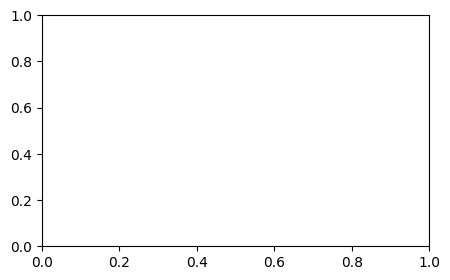

In [1]:
import face_recognition
import cv2
import numpy as np
from datetime import datetime, timedelta
import os
import logging
import dlib
from PIL import Image
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from PIL import Image, ImageTk
import requests
import bz2
import shutil
from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime, Boolean, LargeBinary, ForeignKey, JSON
from sqlalchemy.orm import declarative_base, relationship, sessionmaker
import yaml
import json
from pathlib import Path
import pandas as pd
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import threading
import queue
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import socket
import jwt
from typing import Optional, List, Dict
import hashlib
import uuid
import platform
import psutil
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import time

# Logging ayarları
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('app.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Veritabanı modelleri
Base = declarative_base()

class User(Base):
    __tablename__ = 'users'
    
    id = Column(Integer, primary_key=True)
    username = Column(String, unique=True, nullable=False)
    password_hash = Column(String, nullable=False)
    email = Column(String)
    role = Column(String, default='user')
    is_active = Column(Boolean, default=True)
    last_login = Column(DateTime)
    created_at = Column(DateTime, default=datetime.now)

class Person(Base):
    __tablename__ = 'persons'

    id = Column(Integer, primary_key=True)
    name = Column(String, unique=True, nullable=False)
    face_encoding = Column(LargeBinary, nullable=False)
    is_active = Column(Boolean, default=True)
    created_at = Column(DateTime, nullable=False)
    details = Column(JSON)
    email = Column(String)
    phone = Column(String)
    department = Column(String)
    access_level = Column(Integer, default=1)
    last_seen = Column(DateTime)
    photo_path = Column(String)
    
    recognition_logs = relationship("FaceRecognitionLog", back_populates="person")

class FaceRecognitionLog(Base):
    __tablename__ = 'recognition_logs'

    id = Column(Integer, primary_key=True)
    person_id = Column(Integer, ForeignKey('persons.id'))
    confidence_score = Column(Float)
    timestamp = Column(DateTime, nullable=False)
    location = Column(String)
    device_id = Column(String)
    
    person = relationship("Person", back_populates="recognition_logs")

class SystemLog(Base):
    __tablename__ = 'system_logs'
    
    id = Column(Integer, primary_key=True)
    timestamp = Column(DateTime, default=datetime.now)
    level = Column(String)
    message = Column(String)
    details = Column(JSON)

class SecurityAlert(Base):
    __tablename__ = 'security_alerts'
    
    id = Column(Integer, primary_key=True)
    timestamp = Column(DateTime, default=datetime.now)
    alert_type = Column(String)
    message = Column(String)
    is_handled = Column(Boolean, default=False)
    handled_by = Column(Integer, ForeignKey('users.id'))
    details = Column(JSON)

# Güvenlik Yöneticisi
class SecurityManager:
    def __init__(self, secret_key: str):
        self.secret_key = secret_key
        
    def generate_token(self, user_id: int, role: str) -> str:
        payload = {
            'user_id': user_id,
            'role': role,
            'exp': datetime.utcnow() + timedelta(days=1)
        }
        return jwt.encode(payload, self.secret_key, algorithm='HS256')
    
    def verify_token(self, token: str) -> Optional[Dict]:
        try:
            return jwt.decode(token, self.secret_key, algorithms=['HS256'])
        except jwt.InvalidTokenError:
            return None
    
    def hash_password(self, password: str) -> str:
        salt = uuid.uuid4().hex
        return hashlib.sha256(salt.encode() + password.encode()).hexdigest() + ':' + salt
    
    def verify_password(self, password: str, hashed_password: str) -> bool:
        password_hash, salt = hashed_password.split(':')
        return password_hash == hashlib.sha256(salt.encode() + password.encode()).hexdigest()

# Sistem Monitörü
class SystemMonitor:
    def __init__(self):
        self.start_time = datetime.now()
    
    def get_system_info(self) -> Dict:
        return {
            'platform': platform.platform(),
            'python_version': platform.python_version(),
            'cpu_usage': psutil.cpu_percent(),
            'memory_usage': psutil.virtual_memory().percent,
            'disk_usage': psutil.disk_usage('/').percent,
            'uptime': str(datetime.now() - self.start_time),
            'network': self.get_network_info()
        }
    
    def get_network_info(self) -> Dict:
        try:
            hostname = socket.gethostname()
            ip_address = socket.gethostbyname(hostname)
            return {
                'hostname': hostname,
                'ip_address': ip_address
            }
        except:
            return {'error': 'Ağ bilgisi alınamadı'}
    
    def log_system_status(self, db_session):
        try:
            info = self.get_system_info()
            log = SystemLog(
                level='INFO',
                message='System Status Update',
                details=info
            )
            db_session.add(log)
            db_session.commit()
        except Exception as e:
            logger.error(f"Sistem durumu loglanırken hata: {str(e)}")

# Yüz Tanıma Sınıfı
class FaceRecognition:
    def __init__(self, db_session):
        self.db_session = db_session
        self.known_face_encodings = []
        self.known_face_names = []
        self.load_known_faces()
        
    def load_known_faces(self):
        try:
            persons = self.db_session.query(Person).filter_by(is_active=True).all()
            for person in persons:
                if person.face_encoding:
                    self.known_face_encodings.append(np.frombuffer(person.face_encoding))
                    self.known_face_names.append(person.name)
        except Exception as e:
            logger.error(f"Yüzler yüklenirken hata: {str(e)}")
    
    def encode_face(self, image_path: str) -> Optional[np.ndarray]:
        try:
            image = face_recognition.load_image_file(image_path)
            face_locations = face_recognition.face_locations(image)
            if not face_locations:
                return None
            return face_recognition.face_encodings(image, face_locations)[0]
        except Exception as e:
            logger.error(f"Yüz kodlama hatası: {str(e)}")
            return None
    
    def add_face(self, image_path: str, name: str) -> bool:
        try:
            encoding = self.encode_face(image_path)
            if encoding is None:
                return False
                
            person = Person(
                name=name,
                face_encoding=encoding.tobytes(),
                created_at=datetime.now(),
                photo_path=image_path
            )
            self.db_session.add(person)
            self.db_session.commit()
            
            self.known_face_encodings.append(encoding)
            self.known_face_names.append(name)
            
            return True
        except Exception as e:
            logger.error(f"Yüz ekleme hatası: {str(e)}")
            return False
    
    def recognize_face(self, face_encoding: np.ndarray) -> str:
        try:
            if not self.known_face_encodings:
                return "Bilinmeyen"
            
            matches = face_recognition.compare_faces(
                self.known_face_encodings,
                face_encoding,
                tolerance=0.6
            )
            
            if True in matches:
                first_match_index = matches.index(True)
                name = self.known_face_names[first_match_index]
                
                person = self.db_session.query(Person).filter_by(name=name).first()
                if person:
                    log = FaceRecognitionLog(
                        person_id=person.id,
                        confidence_score=1.0,
                        timestamp=datetime.now()
                    )
                    self.db_session.add(log)
                    self.db_session.commit()
                
                return name
            
            return "Bilinmeyen"
        except Exception as e:
            logger.error(f"Yüz tanıma hatası: {str(e)}")
            return "Hata"

# Ana Uygulama Sınıfı
class FaceRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.config = self.load_config()
        self.setup_database()
        self.security = SecurityManager(self.config['security']['secret_key'])
        self.system_monitor = SystemMonitor()
        
        self.camera_active = False
        self.cap = None
        self.face_recognizer = None
        self.setup_gui()
        
        self.processing_queue = queue.Queue()
        self.processing_thread = threading.Thread(target=self.process_queue, daemon=True)
        self.processing_thread.start()
        
        self.start_monitoring()

    def load_config(self):
        try:
            with open('config/config.yaml', 'r', encoding='utf-8') as f:
                return yaml.safe_load(f)
        except Exception as e:
            logger.error(f"Konfigürasyon yüklenirken hata: {str(e)}")
            raise

    def setup_database(self):
        try:
            engine = create_engine(self.config['database']['url'])
            Base.metadata.create_all(engine)
            Session = sessionmaker(bind=engine)
            self.db_session = Session()
            self.face_recognizer = FaceRecognition(self.db_session)
        except Exception as e:
            logger.error(f"Veritabanı kurulumu hatası: {str(e)}")
            raise

    def setup_gui(self):
        self.root.title(self.config['gui']['window_title'])
        self.root.geometry(f"{self.config['gui']['window_width']}x{self.config['gui']['window_height']}")
        
        self.create_menu()
        
        self.main_frame = ttk.Frame(self.root, padding="10")
        self.main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        self.camera_frame = ttk.LabelFrame(self.main_frame, text="Kamera Görüntüsü")
        self.camera_frame.grid(row=0, column=0, padx=5, pady=5, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        self.camera_label = ttk.Label(self.camera_frame)
        self.camera_label.grid(row=0, column=0, padx=5, pady=5)
        
        self.control_frame = ttk.LabelFrame(self.main_frame, text="Kontroller")
        self.control_frame.grid(row=1, column=0, padx=5, pady=5, sticky=(tk.W, tk.E))
        
        ttk.Button(self.control_frame, text="Kamera Başlat/Durdur", command=self.toggle_camera).grid(row=0, column=0, padx=5, pady=5)
        ttk.Button(self.control_frame, text="Kişi Ekle", command=self.add_person_dialog).grid(row=0, column=1, padx=5, pady=5)
        ttk.Button(self.control_frame, text="Rapor Oluştur", command=self.generate_report).grid(row=0, column=2, padx=5, pady=5)
        
        self.stats_frame = ttk.LabelFrame(self.main_frame, text="İstatistikler")
        self.stats_frame.grid(row=0, column=1, padx=5, pady=5, sticky=(tk.N, tk.S))
        
        self.create_stats_widgets()
        
        self.log_frame = ttk.LabelFrame(self.main_frame, text="Sistem Logları")
        self.log_frame.grid(row=1, column=1, padx=5, pady=5, sticky=(tk.W, tk.E))
        
        self.log_text = tk.Text(self.log_frame, height=10, width=40)
        self.log_text.grid(row=0, column=0, padx=5, pady=5)
        
        self.status_var = tk.StringVar(value="Hazır")
        self.status_bar = ttk.Label(self.root, textvariable=self.status_var)
        self.status_bar.grid(row=2, column=0, columnspan=2, sticky=(tk.W, tk.E))

    def create_menu(self):
        menubar = tk.Menu(self.root)
        self.root.config(menu=menubar)
        
        file_menu = tk.Menu(menubar, tearoff=0)
        menubar.add_cascade(label="Dosya", menu=file_menu)
        file_menu.add_command(label="Kişi Ekle", command=self.add_person_dialog)
        file_menu.add_command(label="Veritabanı Yedekle", command=self.backup_database)
        file_menu.add_separator()
        file_menu.add_command(label="Çıkış", command=self.root.quit)
        
        tools_menu = tk.Menu(menubar, tearoff=0)
        menubar.add_cascade(label="Araçlar", menu=tools_menu)
        tools_menu.add_command(label="Sistem Durumu", command=self.show_system_status)
        tools_menu.add_command(label="Log Görüntüleyici", command=self.show_logs)
        
        reports_menu = tk.Menu(menubar, tearoff=0)
        menubar.add_cascade(label="Raporlar", menu=reports_menu)
        reports_menu.add_command(label="Günlük Rapor", command=lambda: self.generate_report('daily'))
        reports_menu.add_command(label="Haftalık Rapor", command=lambda: self.generate_report('weekly'))
        reports_menu.add_command(label="Aylık Rapor", command=lambda: self.generate_report('monthly'))

    def create_stats_widgets(self):
        self.fig, self.ax = plt.subplots(figsize=(5, 3))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.stats_frame)
        self.canvas.get_tk_widget().grid(row=0, column=0, padx=5, pady=5)
        
        self.total_recognitions_var = tk.StringVar(value="Toplam Tanıma: 0")
        self.success_rate_var = tk.StringVar(value="Başarı Oranı: %0")
        
        ttk.Label(self.stats_frame, textvariable=self.total_recognitions_var).grid(row=1, column=0, padx=5, pady=2)
        ttk.Label(self.stats_frame, textvariable=self.success_rate_var).grid(row=2, column=0, padx=5, pady=2)

    def update_stats(self):
        total = self.db_session.query(FaceRecognitionLog).count()
        success = self.db_session.query(FaceRecognitionLog).filter(FaceRecognitionLog.confidence_score > 0.8).count()
        success_rate = (success / total * 100) if total > 0 else 0
        
        self.total_recognitions_var.set(f"Toplam Tanıma: {total}")
        self.success_rate_var.set(f"Başarı Oranı: %{success_rate:.1f}")
        
        self.ax.clear()
        self.ax.bar(['Başarılı', 'Başarısız'], [success, total - success])
        self.ax.set_title('Tanıma İstatistikleri')
        self.canvas.draw()

    def toggle_camera(self):
        if not self.camera_active:
            try:
                self.cap = cv2.VideoCapture(0)
                if not self.cap.isOpened():
                    raise Exception("Kamera açılamadı!")
                
                self.camera_active = True
                self.update_camera()
                self.status_var.set("Kamera aktif")
            except Exception as e:
                messagebox.showerror("Hata", str(e))
        else:
            self.camera_active = False
            if self.cap:
                self.cap.release()
            self.status_var.set("Kamera kapalı")

    def update_camera(self):
        if self.camera_active:
            ret, frame = self.cap.read()
            if ret:
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                face_locations = face_recognition.face_locations(rgb_frame)
                face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
                
                for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
                    name = self.face_recognizer.recognize_face(face_encoding)
                    color = (0, 255, 0) if name != "Bilinmeyen" else (0, 0, 255)
                    cv2.rectangle(frame, (left, top), (right, bottom), color, 2)
                    cv2.putText(frame, name, (left, top - 10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
                
                image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                photo = ImageTk.PhotoImage(image=image)
                self.camera_label.configure(image=photo)
                self.camera_label.image = photo
                
                self.update_stats()
            
            self.root.after(10, self.update_camera)

    def add_person_dialog(self):
        dialog = tk.Toplevel(self.root)
        dialog.title("Kişi Ekle")
        dialog.geometry("400x300")
        dialog.transient(self.root)
        
        form_frame = ttk.Frame(dialog, padding="20")
        form_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        ttk.Label(form_frame, text="İsim:").grid(row=0, column=0, sticky=tk.W, pady=5)
        name_var = tk.StringVar()
        name_entry = ttk.Entry(form_frame, textvariable=name_var)
        name_entry.grid(row=0, column=1, sticky=(tk.W, tk.E), pady=5)
        
        ttk.Label(form_frame, text="Departman:").grid(row=1, column=0, sticky=tk.W, pady=5)
        dept_var = tk.StringVar()
        dept_entry = ttk.Entry(form_frame, textvariable=dept_var)
        dept_entry.grid(row=1, column=1, sticky=(tk.W, tk.E), pady=5)
        
        ttk.Label(form_frame, text="Email:").grid(row=2, column=0, sticky=tk.W, pady=5)
        email_var = tk.StringVar()
        email_entry = ttk.Entry(form_frame, textvariable=email_var)
        email_entry.grid(row=2, column=1, sticky=(tk.W, tk.E), pady=5)
        
        photo_path_var = tk.StringVar()
        ttk.Label(form_frame, text="Fotoğraf:").grid(row=3, column=0, sticky=tk.W, pady=5)
        photo_label = ttk.Label(form_frame, textvariable=photo_path_var)
        photo_label.grid(row=3, column=1, sticky=(tk.W, tk.E), pady=5)
        
        def select_photo():
            file_path = filedialog.askopenfilename(
                title="Fotoğraf Seç",
                filetypes=[
                    ("Resim Dosyaları", "*.jpg *.jpeg *.png"),
                    ("Tüm Dosyalar", "*.*")
                ]
            )
            if file_path:
                photo_path_var.set(os.path.basename(file_path))
                return file_path
            return None
        
        def save_person():
            name = name_var.get().strip()
            dept = dept_var.get().strip()
            email = email_var.get().strip()
            photo = photo_path_var.get()
            
            if not all([name, dept, email, photo]):
                messagebox.showerror("Hata", "Lütfen tüm alanları doldurun!")
                return
            
            try:
                success = self.face_recognizer.add_face(photo, name)
                if success:
                    person = Person(
                        name=name,
                        department=dept,
                        email=email,
                        created_at=datetime.now(),
                        is_active=True,
                        details={
                            'added_by': 'admin',
                            'added_from': 'gui'
                        }
                    )
                    
                    self.db_session.add(person)
                    self.db_session.commit()
                    
                    logger.info(f"Yeni kişi eklendi: {name}")
                    self.add_log(f"Yeni kişi eklendi: {name}")
                    
                    messagebox.showinfo("Başarılı", f"{name} başarıyla eklendi!")
                    dialog.destroy()
                else:
                    messagebox.showerror("Hata", "Fotoğrafta yüz bulunamadı!")
                
            except Exception as e:
                self.db_session.rollback()
                logger.error(f"Kişi eklenirken hata: {str(e)}")
                messagebox.showerror("Hata", f"Kişi eklenirken hata oluştu: {str(e)}")
        
        button_frame = ttk.Frame(form_frame)
        button_frame.grid(row=4, column=0, columnspan=2, pady=20)
        
        ttk.Button(button_frame, text="Fotoğraf Seç", command=select_photo).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="Kaydet", command=save_person).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="İptal", command=dialog.destroy).pack(side=tk.LEFT, padx=5)
        
        dialog.grab_set()
        name_entry.focus()

    def process_queue(self):
        while True:
            try:
                func, args = self.processing_queue.get()
                func(*args)
                self.processing_queue.task_done()
            except queue.Empty:
                continue
            except Exception as e:
                logger.error(f"İşlem hatası: {str(e)}")

    def start_monitoring(self):
        def monitor():
            while True:
                self.system_monitor.log_system_status(self.db_session)
                time.sleep(300)
        
        threading.Thread(target=monitor, daemon=True).start()

    def show_system_status(self):
        info = self.system_monitor.get_system_info()
        status_window = tk.Toplevel(self.root)
        status_window.title("Sistem Durumu")
        status_window.geometry("400x300")
        
        for key, value in info.items():
            ttk.Label(status_window, text=f"{key}: {value}").pack(pady=5)

    def show_logs(self):
        log_window = tk.Toplevel(self.root)
        log_window.title("Log Görüntüleyici")
        log_window.geometry("600x400")
        
        log_text = tk.Text(log_window, wrap=tk.WORD, width=70, height=20)
        log_text.pack(padx=10, pady=10)
        
        scrollbar = ttk.Scrollbar(log_window, orient="vertical", command=log_text.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        log_text.configure(yscrollcommand=scrollbar.set)
        
        logs = self.db_session.query(SystemLog).order_by(SystemLog.timestamp.desc()).limit(100).all()
        for log in logs:
            log_text.insert(tk.END, f"{log.timestamp} - {log.level}: {log.message}\n")
        
        log_text.configure(state="disabled")

    def add_log(self, message: str, level: str = "INFO"):
        try:
            log = SystemLog(
                level=level,
                message=message,
                timestamp=datetime.now()
            )
            self.db_session.add(log)
            self.db_session.commit()
            
            self.log_text.insert(tk.END, f"{log.timestamp} - {level}: {message}\n")
            self.log_text.see(tk.END)
        except Exception as e:
            logger.error(f"Log ekleme hatası: {str(e)}")

    def backup_database(self):
        try:
            backup_path = f"backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.db"
            shutil.copy2('database/face_recognition.db', backup_path)
            messagebox.showinfo("Başarılı", f"Veritabanı yedeklendi: {backup_path}")
        except Exception as e:
            messagebox.showerror("Hata", f"Yedekleme hatası: {str(e)}")

    def generate_report(self, report_type='daily'):
        try:
            report_path = f"rapor_{report_type}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf"
            
            c = canvas.Canvas(report_path, pagesize=letter)
            c.drawString(100, 750, "Yüz Tanıma Sistemi Raporu")
            c.drawString(100, 730, f"Oluşturulma Tarihi: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            
            if report_type == 'daily':
                start_date = datetime.now() - timedelta(days=1)
            elif report_type == 'weekly':
                start_date = datetime.now() - timedelta(weeks=1)
            else:  # monthly
                start_date = datetime.now() - timedelta(days=30)
            
            logs = self.db_session.query(FaceRecognitionLog).filter(
                FaceRecognitionLog.timestamp >= start_date
            ).all()
            
            total = len(logs)
            success = len([log for log in logs if log.confidence_score > 0.8])
            success_rate = (success / total * 100) if total > 0 else 0
            
            c.drawString(100, 700, f"Toplam Tanıma: {total}")
            c.drawString(100, 680, f"Başarılı Tanıma: {success}")
            c.drawString(100, 660, f"Başarı Oranı: %{success_rate:.1f}")
            
            c.save()
            
            messagebox.showinfo("Başarılı", f"Rapor oluşturuldu: {report_path}")
        except Exception as e:
            messagebox.showerror("Hata", f"Rapor oluşturma hatası: {str(e)}")

def main():
    try:
        root = tk.Tk()
        app = FaceRecognitionApp(root)
        root.mainloop()
    except Exception as e:
        logger.error(f"Uygulama başlatılırken hata: {str(e)}")
        messagebox.showerror("Kritik Hata", str(e))

if __name__ == "__main__":
    main() 